In [ ]:
!pip install scikit-learn

In [ ]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD
# https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py

In [ ]:
import numpy as np
from scipy.ndimage import convolve
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import ConfusionMatrixDisplay


def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
X_train.shape
Y_train[0:3]

array([7, 1, 7])

In [ ]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm1 = BernoulliRBM(random_state=0, verbose=True)
rbm2 = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm1", rbm1),("rbm2",rbm2), ("logistic", logistic)])

In [ ]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm1.learning_rate = 0.06
rbm2.learning_rate = 0.06
rbm1.n_iter = 10
rbm2.n_iter = 10


# More components tend to give better prediction performance, but larger
# fitting time
rbm1.n_components = 100
rbm2.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.32s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.42s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.88, time = 0.47s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.63s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.79, time = 0.42s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.96, time = 0.63s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.80, time = 0.67s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.63, time = 0.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.38, time = 0.25s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.25s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.42, time = 0.20s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -25.06, time = 0.30s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.68, time = 0.29s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -24.26, time = 0.29s
[BernoulliRBM] Iteration 5, pseud

LogisticRegression(C=100.0, solver='newton-cg', tol=1)

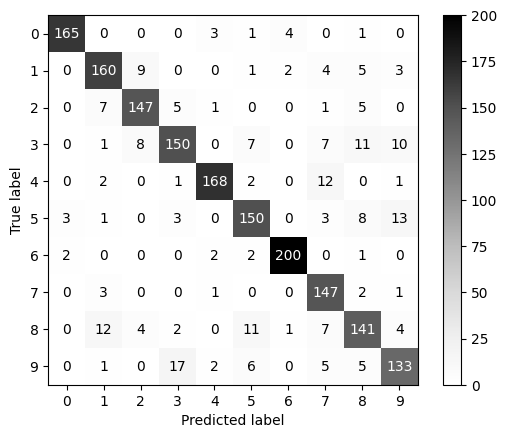

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt


csfont = {'fontname':'serif'} #define the font family


disp = ConfusionMatrixDisplay.from_estimator(
        rbm_features_classifier,
        X_test,
        Y_test,
        display_labels=["0","1","2","3","4","5","6","7","8","9"],
        cmap="Greys",
        normalize=None
    )

plt.savefig("confusion7.3.1A.pdf") #save the figure.
#ax.set_title('Confusion Matrix', fontdict=title_font);
plt.show()



In [ ]:
Y_pred=rbm_features_classifier.predict(X_test)
print("Accuracy of the DBM: ", 100*np.sum(Y_pred-Y_test==0)/Y_pred.size)


Accuracy of the DBM:  86.86700055648302


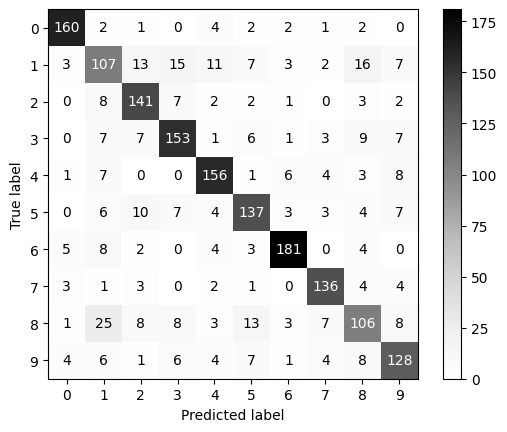

In [ ]:
Y_pred = raw_pixel_classifier.predict(X_test)


disp = ConfusionMatrixDisplay.from_estimator(
        raw_pixel_classifier,
        X_test,
        Y_test,
        display_labels=["0","1","2","3","4","5","6","7","8","9"],
        cmap="Greys",
        normalize=None,
    )

plt.savefig("confusion7.3.1B.pdf") #save the figure.
#ax.set_title('Confusion Matrix', fontdict=title_font);
plt.show()


In [ ]:
Y_pred= raw_pixel_classifier.predict(X_test)
print("Accuracy of the Raw data classifier: ", 100*np.sum(Y_pred-Y_test==0)/Y_pred.size)

Accuracy of the Raw data classifier:  78.18586533110741


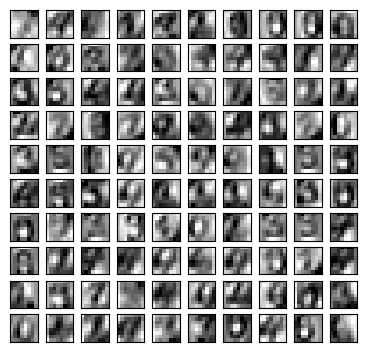

In [ ]:

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm1.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.savefig("features7.3.1.pdf") #save the figure.
plt.show()